## Environment Setup
Let's first setup our environment
- Install all required libraries
- Initialise some constants
- Import the CIFAR10 dataset (in my case I already have it installed)
The CIFAR10 dataset is images so we have to apply a transform to turn the images into tensors

In [37]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data.dataloader import DataLoader

NUM_CLASSES = 10
BATCH_SIZE = 256
IMAGE_DIM = 32
NUM_CHANNELS = 3
KERNEL_SIZE = 2

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
training_dataset = torchvision.datasets.CIFAR10('./data', train=True, transform=transform)
testing_dataset = torchvision.datasets.CIFAR10('./data', train=False, transform=transform)

## Setting up the Network Class
Now onto the main part: Defining our network class
I like to encapsulate and abstract everything into classes so I decided to keep everything (including the training loop) in the network class. 

In [38]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        #Define Layers
        self.dim = 2
        self.network = nn.Sequential(
            nn.Conv2d(3, 3, self.dim, self.dim),
            nn.MaxPool2d(self.dim, self.dim),
            nn.Flatten(),
            nn.Linear(((IMAGE_DIM // (self.dim * 2))**2) * NUM_CHANNELS, NUM_CLASSES),
            nn.Softmax(-1)
        )
        self.training_losses = []
        self.validation_losses = []
    
    def __forward(self, input):
        output = self.network.forward(input)
        return output

    def __accuracy(self, testing_data_loader):
        #Get accuracy on test dataset (just percentage of correct responses)
        for idx, batch in enumerate(testing_data_loader):
            correct = 0
            total = 0
            inputs, labels = batch
            preds = self.__forward(inputs)
            for pred, label in zip(preds, labels):
                if torch.argmax(pred) == label:
                    correct += 1
                total += 1
            return (100 * correct / total)
        
    def predict(self, input):
        return(self.__forward(input))
    
    def train_network(self, training_data_loader, testing_data_loader, epochs, lr, device="cpu"):

        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        loss_fn = nn.CrossEntropyLoss()

        #Iterate for epochs
        for epoch in range(epochs):
            print(f"Epoch Number {epoch}")

            #Set model in train mode
            self.train()

            total_loss = 0
            #Go through every loss
            for idx, batch in enumerate(training_data_loader):
                #Reset gradients
                optimizer.zero_grad()

                inputs, labels = batch
                inputs = inputs.to(device).to(torch.float32)
                labels = labels.to(device)
                
                #Get predictions and calculate loss
                preds = self.__forward(inputs)
                loss = loss_fn(preds, labels)

                #Calculate loss gradients by backpropagating
                loss.backward()

                #Update model weights and biases
                optimizer.step()

                total_loss += loss.item()
            #Get validation loss
            self.eval()
            val_input, val_target = next(iter(test_data_loader))
            val_output = self.__forward(val_input)
            val_loss = loss_fn(val_output, val_target)
            print(f"Loss: {round((total_loss/BATCH_SIZE), 2)}  Val Loss: {round(val_loss.item(), 2)}")
            
            #Get and print accuracy
            accuracy = self.__accuracy(testing_data_loader)
            print(f"Accuracy {round(accuracy, 2)}")
            
            #Append val and train loss to list to use to plot later
            self.training_losses.append(total_loss/BATCH_SIZE)
            self.validation_losses.append(val_loss.item())


## Dataloaders :)
Create PyTorch dataloaders from our train and test datasets. The dataloaders make it so much easier to handle batches.

In [39]:
TEST_DATASET_LEN = 10000

train_data_loader = DataLoader(training_dataset, BATCH_SIZE, True)
test_data_loader = DataLoader(testing_dataset, TEST_DATASET_LEN, False)

## Start Training!
We can declare an instance of our network and begin training with just one line of code

In [42]:
EPOCHS = 10
LEARNING_RATE = 1e-3

device = "cuda" if torch.cuda.is_available() else "cpu"
    
cnn_network = Network().to(device)
cnn_network.train_network(train_data_loader, test_data_loader, EPOCHS, LEARNING_RATE, device)

Epoch Number 0
Loss: 1.71  Val Loss: 2.16
Accuracy 33.84
Epoch Number 1
Loss: 1.63  Val Loss: 2.11
Accuracy 36.29
Epoch Number 2
Loss: 1.61  Val Loss: 2.09
Accuracy 37.65
Epoch Number 3
Loss: 1.6  Val Loss: 2.08
Accuracy 38.45
Epoch Number 4
Loss: 1.59  Val Loss: 2.08
Accuracy 38.83
Epoch Number 5
Loss: 1.59  Val Loss: 2.07
Accuracy 39.61
Epoch Number 6
Loss: 1.58  Val Loss: 2.06
Accuracy 40.0
Epoch Number 7
Loss: 1.58  Val Loss: 2.06
Accuracy 40.5
Epoch Number 8
Loss: 1.58  Val Loss: 2.05
Accuracy 41.09
Epoch Number 9
Loss: 1.57  Val Loss: 2.05
Accuracy 41.88


## Part 2: Visualization
Let's import pyplot from matplotlib and visualize our training and validation losses over epochs

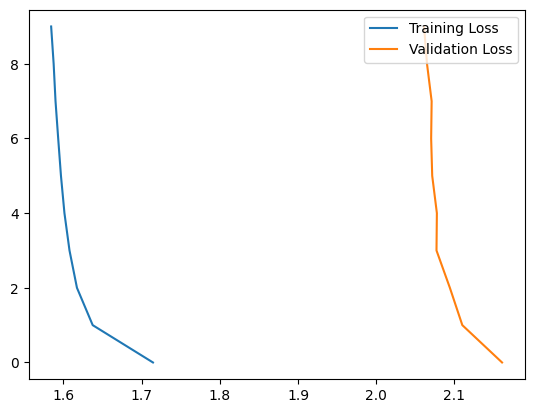

In [35]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(cnn_network.training_losses, np.arange(EPOCHS), label="Training Loss")
plt.plot(cnn_network.validation_losses, np.arange(EPOCHS), label="Validation Loss")
plt.legend(loc="upper right")
plt.show()

# That's It!!
More Possible Steps
- Optimizer Hyperparameters (epochs, batchsize, learning rate)
- Change layer parameters (change kernel or size for conv layer)
- Change Newtork Architecture (Add conv layers or linear layers)